# Evaluation Notebook

This notebook evaluates the performance of the generated model

In [16]:
from keras.models import load_model
from utils import make_logger
import pickle
import matplotlib 
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook
import glob
import itertools
from PIL import Image
import difflib
import seaborn as sns

logger = make_logger('eval', 'log/eval.log')
models_path = os.path.join('models', 'full')

## Plot Train and Test Loss

Load the model and plot losses against epoch.

Plotting Losses


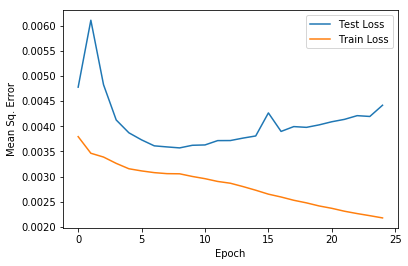

Plotted Losses


In [64]:
logger.info("Plotting Losses")

history = pickle.load(open(os.path.join(models_path, 'history'), "rb"))
fig, ax = plt.subplots()
ax.plot(history['val_loss'], label="Test Loss")
ax.plot(history['loss'], label="Train Loss")
ax.set_ylabel('Mean Sq. Error')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

logger.info("Plotted Losses")

## Define accuracy metric

For my accuracy metric, I get the top similar artists for each artist from the original dataset, then to calculate accuracy of the model, I use the model to calculate all pairwise similarity scores and get the top predicted similar artists. Then I compare the two using edit distance, and return the average value as an accuracy.

Calculating accuracy like this is slow because you pretty much have to go through a full epoch. It's probably only useful at the end of training.

There are two accuracy metrics I use, all of which mean slightly different things:

`compare_accuracy_edit_dist` compares the top n artists in each dataframe by edit distance, and returns it as a proportion to the maximum edit distance possible (i.e. n)

`compare_accuracy_unordered` compares how many of the top n artists are shared between both dataframes, disregarding order, as a proportion of n. 

In [65]:
def similarity_matrix_to_top(matrix):
    # Converts a similarity score matrix to a sorted table of most similar artists
    most_similar = np.argsort(-matrix.values, axis=1)
    return pd.DataFrame(most_similar, index=matrix.index).T

def eval_artist_similarity(artist_A, artist_B, model):
    # Collect all pairwise combinations of artist tracks, evaluates the model on them, then
    # returns the similarity as an average of all the predictions
    audio_A = images[artist_A]
    audio_B = images[artist_B]
    
    X_tmp = [list(), list()]
    for pair in itertools.product(audio_A, audio_B):
        X_tmp[0].append(pair[0])
        X_tmp[1].append(pair[1])
    
    return np.mean(model.predict(X_tmp))

def eval_artist_baseline(artist_A, artist_B):
    # Similar to above, but using baseline evaluation of taking L2 distance between
    # spectrograms and averaging
    audio_A = images[artist_A]
    audio_B = images[artist_B]
    
    dist = []
    for pair in itertools.product(audio_A, audio_B):
        dist.append(np.linalg.norm(pair[0]-pair[1]))
    
    return -np.mean(np.array(dist))

def create_similarity_matrix(artists, model, all_artists = None, baseline = False):
    # Creates a similarity matrix for a list of artists, using a given model to predict similarity
    if all_artists is None:
        all_artists = artists
    df = pd.DataFrame(np.full((len(artists), len(all_artists)), np.nan), columns = all_artists, index = artists)
    for artist_A, artist_B in tqdm_notebook(list(itertools.product(all_artists, artists))):
        if artist_A != artist_B:
            if baseline:
                sim = eval_artist_baseline(artist_A, artist_B)
            else:
                sim = eval_artist_similarity(artist_A, artist_B, model)
            df[artist_A][artist_B] = sim
    return df

def compare_accuracy_edit_dist(df1, df2, n=10):
    # Compares accuracy of two similarity ranking dataframes using edit distance, comparing the top n ranked
    # similar artists
    distances = dict()
    for column in df1:
        distances[column] = difflib.SequenceMatcher(None, df1.head(n)[column], df2.head(n)[column]).ratio()
    return np.mean(np.array(list(distances.values()))), distances

def compare_accuracy_unordered(df1, df2, n=10):
    # Compares accuracy of two similarity ranking dataframes by looking at the size of the unordered union of sets,
    # comparing the top n ranked similar artists
    distances = dict()
    for column in df1:
        distances[column] = len(set(df1.head(n)[column].values).intersection(df2.head(n)[column].values))\
            / len(df1.head(n)[column])
    return np.mean(np.array(list(distances.values()))), distances

## Load the training and test sets and images

Creates a dict relating artist MBIDs to spectrogram images, represented as 128x128x1 arrays of floats. Also load the previously saved database of artist relationships.

In [66]:
logger.info('Loading images')

images = defaultdict(list)

for path in tqdm_notebook(glob.glob('tracks/**/*.png', recursive=True)):
    mbid = os.path.basename(path).rsplit('-', 1)[0]
    img = np.rot90(np.array(Image.open(path).convert('L')) / 255)
    #img = np.reshape(img, img.shape + (1,))
    images[mbid].append(img)
    
logger.info('Loaded images')

Loading images


Loaded images


In [67]:
logger.info('Loading training set')

train_set = pd.read_hdf('dataset/train_min.hd5', key='artists')

logger.info('Loaded training set')

logger.info('Loading test set')

test_set = pd.read_hdf('dataset/test_min.hd5', key='artists')

logger.info('Loaded test set')

Loading training set
Loaded training set
Loading test set
Loaded test set


In [68]:
logger.info('Artists in images: {}'.format(len(images)))
logger.info('Training set length: {}'.format(len(train_set)))
logger.info('Test set length: {}'.format(len(test_set)))

Artists in images: 975
Training set length: 877
Test set length: 975


## Create train/test datasets relating image references to values

Previously, we had the large raw dataset which is of the form `df[artistA][artistB]=similarity`. Here, we create X and Y arrays, with the X array being a list of two arrays, each containing references to one of the spectrogram images that was loaded for a given artist. The Y array is a list containing the similarity scores for the corresponding two artists.

In [69]:
logger.info('Re-formatting datasets for training')

train_dedup = train_set.where(~np.triu(np.ones(train_set.shape)).astype(np.bool))
train_stacked = train_dedup.stack()

test_set.index = test_set.columns.append(test_set.columns.append(test_set.index).drop_duplicates(keep=False))
test_dedup = test_set.where(~np.triu(np.ones(test_set.shape)).astype(np.bool))
test_stacked = test_dedup.stack()

def format_dataset(raw_dataset):
    X_1 = []
    X_2 = []
    Y = []
    
    for index, value in tqdm_notebook(raw_dataset.iteritems(), total = len(raw_dataset)):
        artist_A = index[0]
        artist_B = index[1]
        audio_A = images[artist_A]
        audio_B = images[artist_B]

        for pair in itertools.product(audio_A, audio_B):
            X_1.append(pair[0])
            X_2.append(pair[1])
            Y.append(value)

    Y = np.array(Y)
    X = [X_1, X_2]
    return X, Y

X_train, Y_train = format_dataset(train_stacked)
X_test, Y_test = format_dataset(test_stacked)

logger.info('Datasets formatted')

Re-formatting datasets for training


Datasets formatted


## Generate Similarity and Rank Matrices for Test Set

First we load the model that we trained earlier. Then, using the trained model, we generate a similarity matrix for the artists test set, and use it to evaluate the performance of the model. We also define matrices for the baseline and original test sets to use with our similarity metrics.

In [70]:
logger.info('Loading model')

model = load_model(os.path.join(models_path, "post_train_model.hd5"))

logger.info('Loaded model')

Loading model
Loaded model


In [71]:
logger.info('Generating similarity matrix')

sim_matrix = create_similarity_matrix(test_set.columns, model)
baseline_sim_matrix = create_similarity_matrix(test_set.columns, model, baseline = True)

logger.info('Generated similarity matrix')

Generating similarity matrix


KeyboardInterrupt: 

In [72]:
logger.info('Building ranked matrices')

model_ranked_matrix = similarity_matrix_to_top(sim_matrix)
baseline_ranked_matrix = similarity_matrix_to_top(baseline_sim_matrix)
truth_ranked_matrix = similarity_matrix_to_top(test_set.T[test_set.columns])

logger.info('Built ranked matrices')

Building ranked matrices


NameError: name 'sim_matrix' is not defined

## Evaluate Accuracy 

Evaluates accuracy against the baseline, and where possible, random ordering, for a set of top similar artists per artist (top 3, 5, 10, and 25).

In [103]:
accs = [3, 5, 10, 25]

for acc in accs:
    model_unordered = compare_accuracy_unordered(model_ranked_matrix, truth_ranked_matrix, n=acc)[0]
    model_edit_dist = compare_accuracy_edit_dist(model_ranked_matrix, truth_ranked_matrix, n=acc)[0]
    baseline_unordered = compare_accuracy_unordered(baseline_ranked_matrix, truth_ranked_matrix, n=acc)[0]
    baseline_edit_dist = compare_accuracy_edit_dist(baseline_ranked_matrix, truth_ranked_matrix, n=acc)[0]
    logger.info("n = {}".format(acc))
    logger.info("Unordered distance; model: {}, baseline: {}, random: {}".format(model_unordered, baseline_unordered, 
                                                                                 acc / model_ranked_matrix.shape[0]))
    logger.info("Edit distance; model: {}, baseline: {}".format(model_edit_dist, baseline_edit_dist))

n = 3
Unordered distance; model: 0.1292517006802721, baseline: 0.07482993197278912, random: 0.061224489795918366
Edit distance; model: 0.12244897959183672, baseline: 0.07482993197278912
n = 5
Unordered distance; model: 0.17959183673469387, baseline: 0.13877551020408166, random: 0.10204081632653061
Edit distance; model: 0.1469387755102041, baseline: 0.11428571428571428
n = 10
Unordered distance; model: 0.3163265306122449, baseline: 0.30204081632653057, random: 0.20408163265306123
Edit distance; model: 0.1795918367346939, baseline: 0.16530612244897958
n = 25
Unordered distance; model: 0.5730612244897959, baseline: 0.5542857142857143, random: 0.5102040816326531
Edit distance; model: 0.16326530612244897, baseline: 0.1542857142857143


## Test Early Stopping Model

The model at epoch 5 seemed to perform better, perhaps due to overfitting. Let's load and test that model instead.

In [108]:
logger.info('Loading epoch 5 model')

e5_model = load_model(os.path.join(models_path, "model-05-0.004.hdf5"))

logger.info('Loaded epoch 5 model')

Loading epoch 5 model
Loaded epoch 5 model


In [109]:
logger.info('Generating similarity matrix')

e5_sim_matrix = create_similarity_matrix(test_set.columns, e5_model)

logger.info('Generated similarity matrix')

Generating similarity matrix


Generated similarity matrix


In [110]:
logger.info('Building ranked matrices')

e5_model_ranked_matrix = similarity_matrix_to_top(e5_sim_matrix)

logger.info('Built ranked matrices')

Building ranked matrices
Built ranked matrices


In [111]:
accs = [3, 5, 10, 25]

for acc in accs:
    model_unordered = compare_accuracy_unordered(e5_model_ranked_matrix, truth_ranked_matrix, n=acc)[0]
    model_edit_dist = compare_accuracy_edit_dist(e5_model_ranked_matrix, truth_ranked_matrix, n=acc)[0]
    baseline_unordered = compare_accuracy_unordered(baseline_ranked_matrix, truth_ranked_matrix, n=acc)[0]
    baseline_edit_dist = compare_accuracy_edit_dist(baseline_ranked_matrix, truth_ranked_matrix, n=acc)[0]
    logger.info("n = {}".format(acc))
    logger.info("Unordered distance; model: {}, baseline: {}, random: {}".format(model_unordered, baseline_unordered, 
                                                                                 acc / model_ranked_matrix.shape[0]))
    logger.info("Edit distance; model: {}, baseline: {}".format(model_edit_dist, baseline_edit_dist))

n = 3
Unordered distance; model: 0.09523809523809523, baseline: 0.07482993197278912, random: 0.061224489795918366
Edit distance; model: 0.08843537414965985, baseline: 0.07482993197278912
n = 5
Unordered distance; model: 0.18775510204081636, baseline: 0.13877551020408166, random: 0.10204081632653061
Edit distance; model: 0.15918367346938778, baseline: 0.11428571428571428
n = 10
Unordered distance; model: 0.3551020408163265, baseline: 0.30204081632653057, random: 0.20408163265306123
Edit distance; model: 0.19999999999999998, baseline: 0.16530612244897958
n = 25
Unordered distance; model: 0.5975510204081633, baseline: 0.5542857142857143, random: 0.5102040816326531
Edit distance; model: 0.15020408163265306, baseline: 0.1542857142857143


## Visualize Weights

Visualizes the weights for the first layer of filters, to see what the model learned.

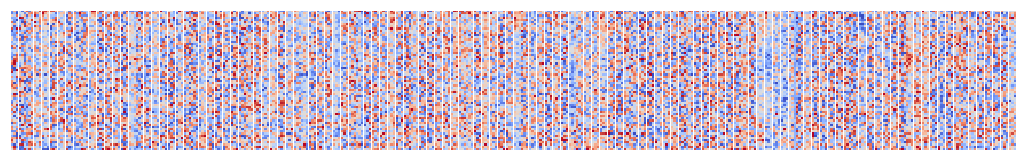

In [173]:
weights = model.layers[2].layers[2].get_weights()[0]

fig, axes = plt.subplots(1, weights.shape[2], frameon=False, figsize=(18,10))

cell_scale = 10

for i in range(weights.shape[2]):
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    axes[i].axis('off')
    axes[i].imshow(weights[:,:,i].T, cmap='coolwarm', extent=(0, cell_scale * 3, 0, 64 * cell_scale))
    
plt.savefig('figures/weights.png')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


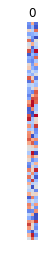

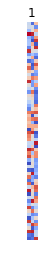

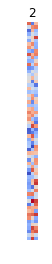

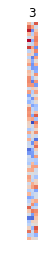

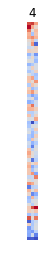

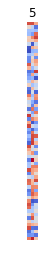

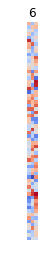

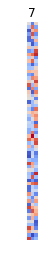

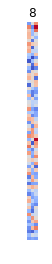

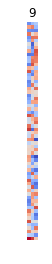

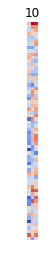

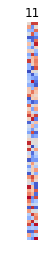

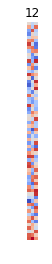

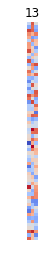

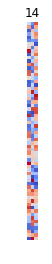

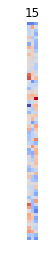

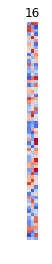

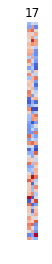

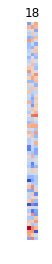

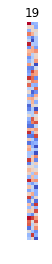

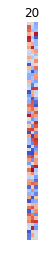

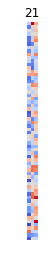

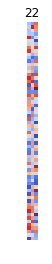

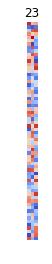

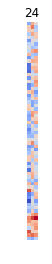

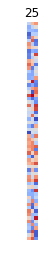

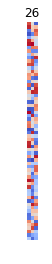

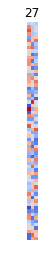

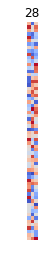

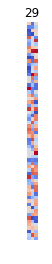

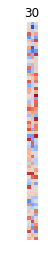

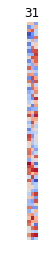

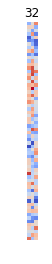

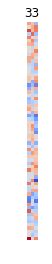

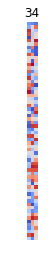

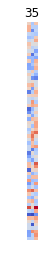

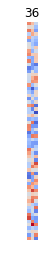

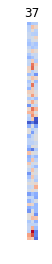

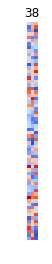

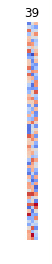

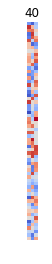

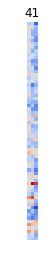

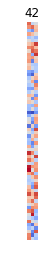

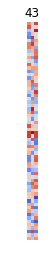

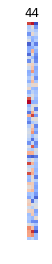

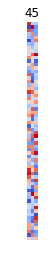

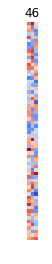

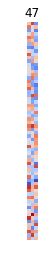

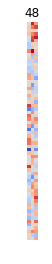

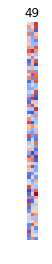

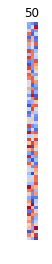

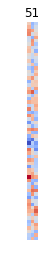

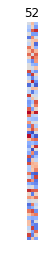

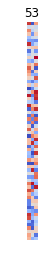

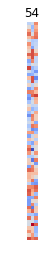

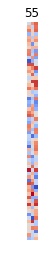

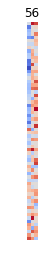

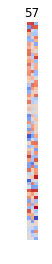

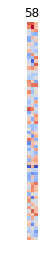

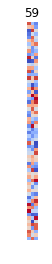

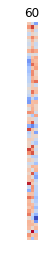

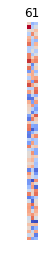

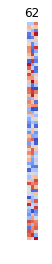

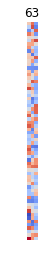

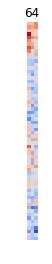

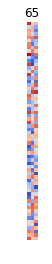

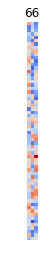

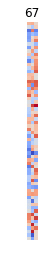

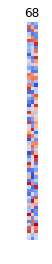

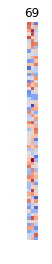

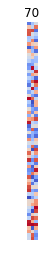

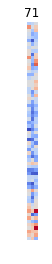

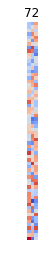

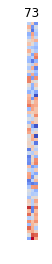

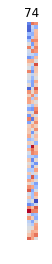

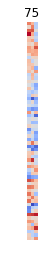

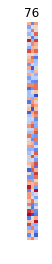

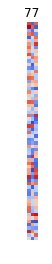

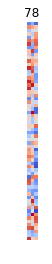

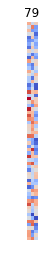

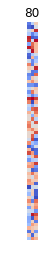

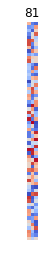

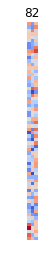

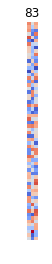

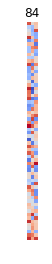

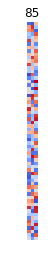

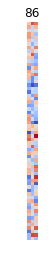

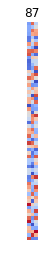

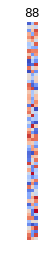

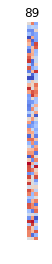

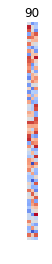

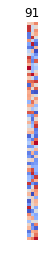

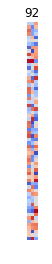

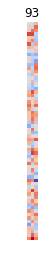

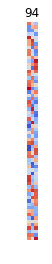

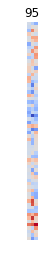

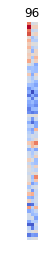

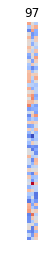

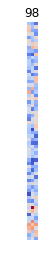

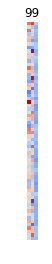

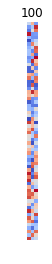

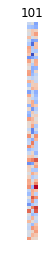

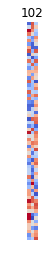

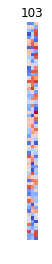

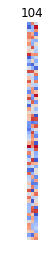

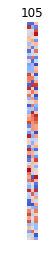

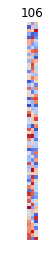

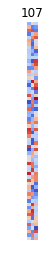

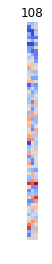

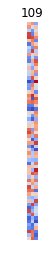

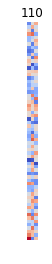

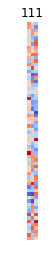

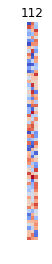

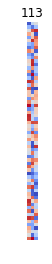

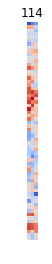

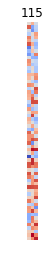

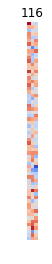

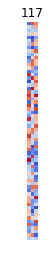

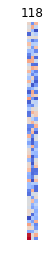

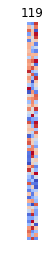

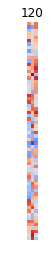

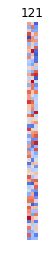

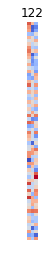

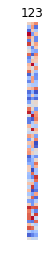

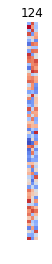

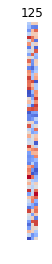

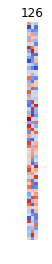

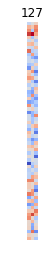

In [148]:
interesting_filters = [4, 64, 99]

for i in range(weights.shape[2]):
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(weights[:,:,i].T, cmap='coolwarm')
    
    if i in interesting_filters:
        plt.savefig('figures/filter-{}.png'.format(i))
    

## Look at predictions for some artists

In [95]:
mbid_to_artist = pd.read_csv('dataset/mbid_to_artist.csv', index_col=0)

logger.info('Loaded mbid_to_artist.csv')

Loaded mbid_to_artist.csv


### The Beatles

In [105]:
mbid_to_artist.loc[train_set.columns[truth_ranked_matrix['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d'].head(5).values]]

,artistname
a74b1b7f-71a5-4011-9441-d0b5e4122711,radiohead
cc197bad-dc9c-440d-a5b5-d52ba2e14234,coldplay
72c536dc-7137-4477-a521-567eeb840fa8,bob dylan
b071f9fa-14b0-4217-8e97-eb41da73f598,the rolling stones
678d88b2-87b0-403b-b63d-5da7465aecc3,led zeppelin


In [115]:
sim_matrix_beatles = create_similarity_matrix(['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d'],model, 
                                              all_artists = np.concatenate([train_set.columns.values, test_set.columns.values]))

In [116]:
model_ranked_matrix_beatles = similarity_matrix_to_top(sim_matrix_beatles)
mbid_to_artist.loc[train_set.columns[model_ranked_matrix_beatles['b10bbbfc-cf9e-42e0-be17-e2c3e1d2600d'].head(5).values]]

,artistname
ba1384a7-8b0e-4ea6-bf0c-f1ec17a06d14,the 69 eyes
65314b12-0e08-43fa-ba33-baaa7b874c15,leonard cohen
5adb8b74-54b8-4700-836e-550b6a2a2f71,cat stevens
0039c7ae-e1a7-4a7d-9b49-0cbc716821a6,death cab for cutie
3ac482b8-1494-4071-a0e9-f192f9d2c2b0,built to spill


### In Flames

In [117]:
mbid_to_artist.loc[train_set.columns[truth_ranked_matrix['31745282-b1ea-4d62-939f-226b14d68e7c'].head(5).values]]

,artistname
f57e14e4-b030-467c-b202-539453f504ec,children of bodom
a466c2a2-6517-42fb-a160-1087c3bafd9f,slipknot
4bb4e4e4-5f66-4509-98af-62dbb90c45c5,disturbed
9d30e408-1559-448b-b491-2f8de1583ccf,dark tranquillity
ca891d65-d9b0-4258-89f7-e6ba29d83767,iron maiden


In [120]:
sim_matrix_if = create_similarity_matrix(['31745282-b1ea-4d62-939f-226b14d68e7c'], model,
                                              all_artists = np.concatenate([train_set.columns.values, test_set.columns.values]))

In [121]:
model_ranked_matrix_if = similarity_matrix_to_top(sim_matrix_if)
mbid_to_artist.loc[train_set.columns[model_ranked_matrix_if['31745282-b1ea-4d62-939f-226b14d68e7c'].head(5).values]]

,artistname
4e0dffde-ad2d-45b7-9c75-d57ce55de061,rhapsody of fire
4b1a830b-0a1f-42e5-b8d5-1d6743912e99,creed
f1c8da15-b408-4149-b863-f1cbe9971f19,mudvayne
5dfdca28-9ddc-4853-933c-8bc97d87beec,marilyn manson
7e26cbe1-b8f5-4215-af82-e43d5f8ff308,cradle of filth


### Tupac

In [127]:
mbid_to_artist.loc[train_set.columns[truth_ranked_matrix['382f1005-e9ab-4684-afd4-0bdae4ee37f2'].head(5).values]]

,artistname
cfbc0924-0035-4d6c-8197-f024653af823,nas
f90e8b26-9e52-4669-a5c9-e28529c47894,snoop dogg
8e68819d-71be-4e7d-b41d-f1df81b01d3f,50 cent
d5d97b2b-b83b-4976-814a-056d9076c8c3,notorious b.i.g.
5f6ab597-f57a-40da-be9e-adad48708203,dr. dre


In [128]:
sim_matrix_2pac = create_similarity_matrix(['382f1005-e9ab-4684-afd4-0bdae4ee37f2'], model,
                                              all_artists = np.concatenate([train_set.columns.values, test_set.columns.values]))

In [131]:
model_ranked_matrix_2pac = similarity_matrix_to_top(sim_matrix_2pac)
mbid_to_artist.loc[train_set.columns[model_ranked_matrix_2pac['382f1005-e9ab-4684-afd4-0bdae4ee37f2'].head(5).values]]

,artistname
1138a764-2212-4d0a-b02d-0dc14df91e08,akon
f82bcf78-5b69-4622-a5ef-73800768d9ac,jay-z
8e68819d-71be-4e7d-b41d-f1df81b01d3f,50 cent
ac9a487a-d9d2-4f27-bb23-0f4686488345,lil wayne
1fda852b-92e9-4562-82fa-c52820a77b23,the pussycat dolls


In [175]:
model.layers[2].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 256, 64)           0         
_________________________________________________________________
zero_padding1d_13 (ZeroPaddi (None, 258, 64)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 256, 128)          24704     
_________________________________________________________________
batch_normalization_13 (Batc (None, 256, 128)          512       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 64, 128)           0         
_________________________________________________________________
zero_padding1d_14 (ZeroPaddi (None, 66, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 64, 128)           49280     
__________